In [341]:
import pandas as pd
import matplotlib.pyplot as plt

In [342]:
# Define constants
COUNT_THRESHOLD = 5  # Count threshold for labeling a node as a leaf
MAX_DEPTH = 3 # Maximum depth for the decision tree

In [343]:
# Function 1: Calculate Gini Impurity
def calculate_gini(data):
    total=len(data)
    temp=dict()
    for x in data:
        temp[x[-1]]=0
    for x in data:
        temp[x[-1]]+=1
    s=0
    for x in temp.values():
        s+=((x/total)**2)
    return 1-s

In [344]:
# Function 2: Split dataset by an attribute
def split_data(data, attribute_index, value):
    l=list()
    for x in data:
        if x[attribute_index]==value:
            l.append(x)
    return l

In [345]:
# Function 3: Calculate Gini Gain
def gini_gain(data, attribute_index):
    total=calculate_gini(data)
    d=dict()
    for x in data:
        d[x[attribute_index]]=0
    z=d.keys()
    y=list()
    for x in z:
        y.append(x)
    i=0
    l=list()
    s=0
    while i<len(y):
        l=split_data(data,attribute_index,y[i])
        z=calculate_gini(l)
        weight=len(l)/len(data)
        s+=(z*weight)
        i+=1
    return (total-s)


In [346]:

def find_label(data):
    temp=dict()
    for x in data:
        temp[x[-1]]=0
    for x in data:
        temp[x[-1]]+=1
    y=list(temp.values())
    k=max(y)
    for x in temp.keys():
        if temp[x]==k:
            return x

In [347]:
# Function 4: Build the Decision Tree
def build_tree(data, attributes, depth=0):
    # This is what a decision tree should look like
    # {2: {'Single': {3: {'Low': 'Yes', 'Medium': 'No', 'High': {1: {'Low': 'Yes', 'High': 'No'}}}}, 'Married': 'Yes', 'Divorced': 'No'}}
    tree=dict()
    if depth>=MAX_DEPTH or len(attributes)==0 or calculate_gini(data)==0 or len(data)<COUNT_THRESHOLD:
        return find_label(data)
    else:
        x=y=0
        for i in attributes:
                if y<gini_gain(data,i):
                    y=gini_gain(data,i)
                    x=i
        n=list()
        for z in attributes:
              if z!=x:
                    n.append(z) 
        tree[x]=dict()          
        for z in set(row[x] for row in data):
                tempdata=split_data(data,x,z)
                tree[x][z]=build_tree(tempdata,n,depth+1)  
        return tree 

In [348]:
# Function 5: Predict a Single Instance
def predict(tree, instance):
    """
    Predicts the label for a single instance using the decision tree.

    Args:
        tree: The decision tree (dictionary).
        instance: A dictionary where keys are attribute indices and values are the instance's attribute values.

    Returns:
        The predicted label for the instance.
    """
    # Hint: Traverse the tree based on the instance's attribute values.
    # Hint: If the current node is a dictionary, look up the next branch using the instance value.
    # Hint: If the current node is not a dictionary, return it as the predicted label.
    root=list(tree.keys())[0]
    node=tree[root][instance[root]]
    while True:
        if not isinstance(node,dict):
            return node
        else:
            root=list(node.keys())[0]
            node=node[root][instance[root]]
            continue

In [349]:
# Load the dataset from the CSV file
df = pd.read_csv("car_evaluation.csv")

# Define a mapping for the categorical values to numerical values
value_mappings = {
    'buying': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'maint': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2}
}

# Apply the mappings to the dataset
for column, mapping in value_mappings.items():
    df[column] = df[column].map(mapping)

# Extract the features and target
X = df.drop(columns=['class'])  # Drop the target column
y = df['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})  # Map target to numerical values

# Convert DataFrame to list for the decision tree
data = df.values.tolist()
attributes = list(range(len(X.columns)))  # Indexes of the attributes (buying, maint, etc.)
attribute_names = list(X.columns)  # Get the actual attribute names


In [354]:
# Build the decision tree
tree = build_tree(data, attributes)
print("Decision Tree:", tree)

Decision Tree: {5: {0: 'unacc', 1: {3: {0: 'unacc', 1: {0: {0: 'acc', 1: 'acc', 2: 'unacc', 3: 'unacc'}}, 2: {4: {0: 'unacc', 1: 'acc', 2: 'acc'}}}}, 2: {3: {0: 'unacc', 1: {0: {0: 'acc', 1: 'acc', 2: 'acc', 3: 'unacc'}}, 2: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}}}}}


<Figure size 1400x800 with 0 Axes>

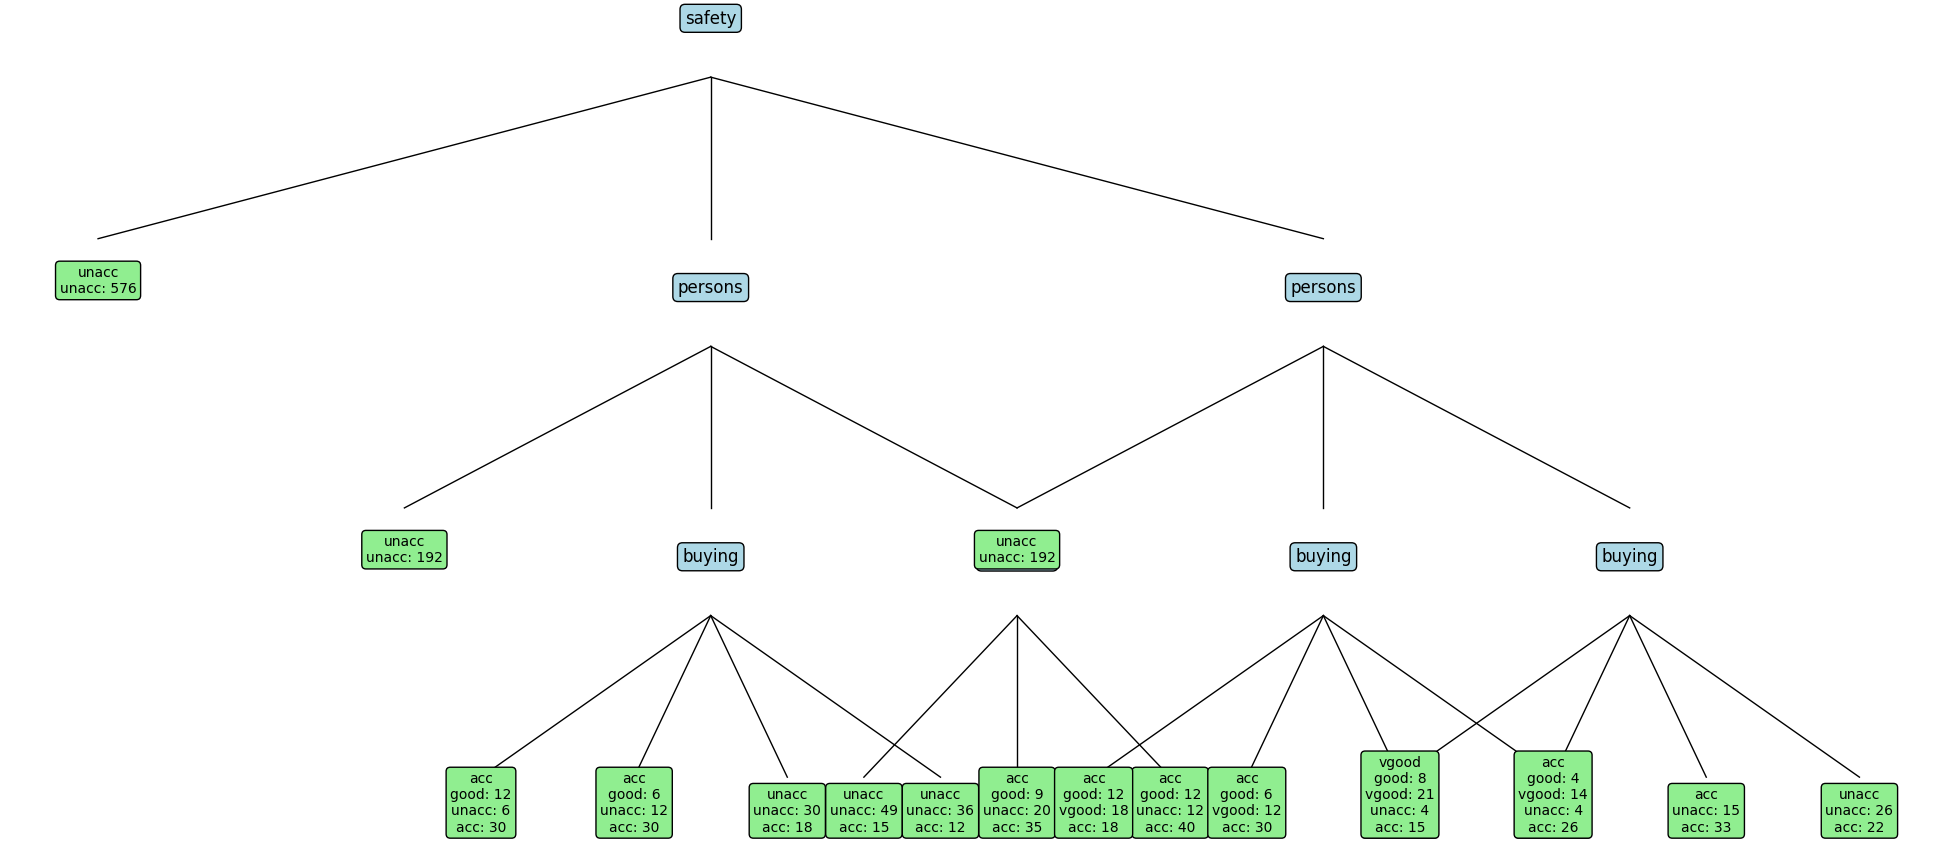

In [353]:

# Visualize the decision tree
def plot_tree(tree, depth=0, x_offset=0.5, y_offset=1.0, x_gap=0.25, ax=None, data=None, attribute_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(25, 10))
        ax.axis('off')  # Turn off the axes

    # If the tree is a leaf node, plot the label and counts
    if not isinstance(tree, dict):
        # Count the occurrences of each label in the current leaf data subset
        label_counts = {label: sum(1 for row in data if row[-1] == label) for label in set(row[-1] for row in data)}
        # Format the label text to include counts of each class
        label_text = f"{tree}\n" + "\n".join([f"{label}: {count}" for label, count in label_counts.items()])
        ax.text(x_offset, y_offset, label_text, fontsize=10, ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", edgecolor="black"))
        return

    # Get the current decision attribute name
    root = list(tree.keys())[0]
    attribute_name = attribute_names[root]  # Map the index to the attribute name
    ax.text(x_offset, y_offset, f"{attribute_name}", fontsize=12, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", edgecolor="black"))

    # Recursively plot child nodes
    num_children = len(tree[root])
    for i, (value, subtree) in enumerate(tree[root].items()):
        child_x = x_offset + (i - (num_children - 1) / 2) * x_gap  # Calculate child x position
        child_y = y_offset - 0.1  # Shift vertically for the child nodes

        # Draw a line to the child node
        ax.plot([x_offset, child_x], [y_offset - 0.02, child_y + 0.02], 'k-', lw=1)

        # Recursively call plot_tree for the child node, passing the subset of data that corresponds to the child
        subset = split_data(data, root, value)  # Get the subset of data for this child
        plot_tree(subtree, depth + 1, child_x, child_y, x_gap / 2, ax=ax, data=subset, attribute_names=attribute_names)

    if depth == 0:  # Show the plot only at the top level
        plt.show()



# Visualize the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree, data=data, attribute_names=attribute_names)

In [ ]:
# Test prediction
test_instance = {0: 1, 1: 2}  # Middle-aged with High income
prediction = predict(tree, test_instance)
print("\nPrediction for test instance:", "Yes" if prediction == 1 else "No")